In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import tensorboard as tb
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
from tqdm import tqdm

In [2]:
sns.set(font_scale=1.5)

In [3]:
# https://github.com/theRealSuperMario/supermariopy/blob/master/scripts/tflogs2pandas.py
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs

In [4]:
def load_models(dir):
    all_logs = pd.DataFrame()
    models = next(os.walk(dir))[1]
    for model in tqdm(models):
        model_path = os.path.join(dir, model)
        runs = next(os.walk(model_path))[1]
        for run in runs:
            path = os.path.join(model_path, run)
            log = tflog2pandas(path)
            log['run'] = run
            log['model'] = model
            # string_splits = run.split('_')
            # log['tag'] = string_splits[0]
            # log['model'] = string_splits[1]
            # hp = ', '.join(string_splits[2:-3])
            # if string_splits[1] == 'GecoVAE':
            #     hp = hp.replace(", 255,", ",")
            #     hp = hp.replace("lambda, init", "lambda_init")
            # log['hyperparams'] = hp
            # log['seed'] = string_splits[-3][4:]
            # log['date'] = string_splits[-2] + "_" + string_splits[-1]

            if log is not None:
                if all_logs.shape[0] == 0:
                    all_logs = log
                else:
                    all_logs = all_logs.append(log, ignore_index=True)


    # create dataframe with final values
    # dff = all_logs[all_logs.step == all_logs.step.max()]
    # dff = dff.pivot_table(index=["run", "tag", "model", "hyperparams", "seed", "date"], columns=["metric"],values="value")
    # dff = pd.DataFrame(dff.to_records())
    return all_logs #, dff

In [5]:
dir = './carla/agents/.data_/'
df = load_models(dir)

100%|██████████| 3/3 [01:42<00:00, 34.17s/it]


In [6]:
df

,metric,value,step,run,model
0,stats/EpRet,-0.485263,0.0,inv_res_s26912,inv_res
1,stats/EpRet,-0.506250,1.0,inv_res_s26912,inv_res
2,stats/EpRet,-0.112000,2.0,inv_res_s26912,inv_res
3,stats/EpRet,-0.273913,3.0,inv_res_s26912,inv_res
4,stats/EpRet,-0.144167,4.0,inv_res_s26912,inv_res
...,...,...,...,...,...
2123200,eval_stats/context_89/GoalReached,1.000000,55.0,nc2048_s44864,nc2048
2123201,eval_stats/context_89/GoalReached,1.000000,56.0,nc2048_s44864,nc2048
2123202,eval_stats/context_89/GoalReached,1.000000,57.0,nc2048_s44864,nc2048
2123203,eval_stats/context_89/GoalReached,1.000000,58.0,nc2048_s44864,nc2048


[Text(0.5, 0, 'Cummulative Reward'), Text(0, 0.5, '')]

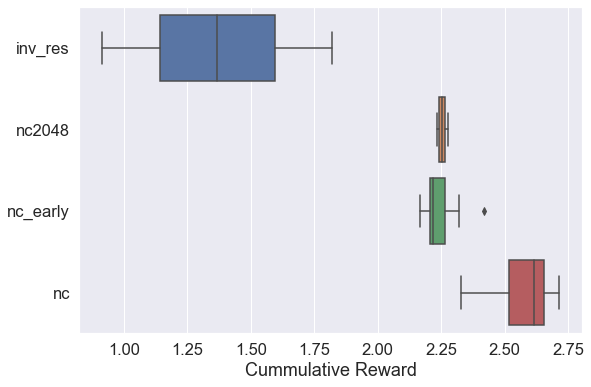

In [23]:
clist = ["inv_res", "nc2048", "nc_early", "nc" ] #"nc2048",
a = df
a = a[a.metric == "eval_stats/AvgEpRet"]
c = a[a.step == a.step.max()]
c = c[c.model.isin(clist)]
b = a[a.step == 29]
b = b[b.model == 'nc']
b["model"] = "nc_early"
c = pd.concat([c, b])
plt.figure(figsize=(9, 6))
order = clist
sns.boxplot(data=c, y="model", x="value", order=order).set(xlabel="Cummulative Reward", ylabel=None)


Text(0.5, 1.0, 'reward by Config')

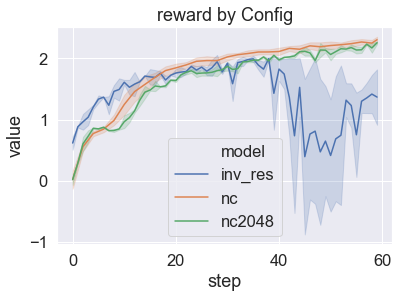

In [22]:
t = df[df["model"].isin(["inv_res", "nc2048", "nc"])]
t.loc[t["model"] == "nc", "step"] *=2
t.loc[t.step == 60, "step"] = 59
t = t[t.step < 60]
sns.lineplot(data=t[t.metric == "eval_stats/AvgEpRet"], x="step", y="value", hue="model").set_title("reward by Config")

In [8]:
c

,metric,value,step,run,model
149679,eval_stats/AvgEpRet,1.819994,59.0,inv_res_s26912,inv_res
326544,eval_stats/AvgEpRet,0.914906,59.0,inv_res_s44864,inv_res
503504,eval_stats/AvgEpRet,2.446862,59.0,nc_s24946,nc
680469,eval_stats/AvgEpRet,2.330034,59.0,nc_s26912,nc
857424,eval_stats/AvgEpRet,2.631533,59.0,nc_s34416,nc
1034394,eval_stats/AvgEpRet,2.639339,59.0,nc_s44864,nc
1211369,eval_stats/AvgEpRet,2.540045,59.0,nc_s65066,nc
1388329,eval_stats/AvgEpRet,2.707345,59.0,nc_s73735,nc
1565314,eval_stats/AvgEpRet,2.713689,59.0,nc_s88994,nc
1742309,eval_stats/AvgEpRet,2.602783,59.0,nc_s94869,nc
